# Chapter 16: Are Shewhart's Limits Different?

For additional context see Chapter 16 of [The Virus of Variation](https://www.brokenquality.com/book). Questions? Email James.Lehner@gmail.com or QualityIsBroken@gmail.com.

In [9]:
# Import libraries
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import seaborn as sns
import pandas as pd
from process_improvement import xmr_charts as xmr

%matplotlib inline

## Get the data

The dataset used in this chapter is called:

`sales-by-region.csv`

The dataset can be found at https://github.com/jimlehner/the-virus-of-variation/tree/main/data.

In [2]:
# Get data function
def get_data(dataset_url) -> pd.DataFrame:
    return pd.read_csv(dataset_url)

In [3]:
# Sales dataset url
sales_url = r'https://raw.githubusercontent.com/jimlehner/the-virus-of-variation/refs/heads/main/data/sales-by-regions.csv'

# Get data
sales_df = get_data(sales_url)

# Make 'Month' column dtype string
sales_df['Month'] = sales_df['Month'].astype('string')

# Show dataframe
sales_df.head()

,Month,East Region,West Region
0,Jan,10.7,6.9
1,Feb,13.0,11.3
2,Mar,11.4,9.3
3,Apr,11.5,9.8
4,May,12.5,18.7


In [4]:
# Split sales_df according to region
df_east = sales_df[['Month', 'East Region']].copy()
df_west = sales_df[['Month', 'West Region']].copy()

# Rename the columns for clarity (optional)
df_east.columns = ['Month', 'Sales']
df_west.columns = ['Month', 'Sales']

# Calculate moving ranges for both regions
df_east['Moving Ranges'] = abs(df_east['Sales'].diff())
df_west['Moving Ranges'] = abs(df_west['Sales'].diff())

# Create list of dataframes
df_list = [df_east, df_west]
plot_label_names = ['East Region','West Region']

## Calculate process statistics using different measures of dispersion

In [5]:
# Create helper function for calculating process statistics
def region_stats(df, name, print_summary=True, round_value=2):
    # Specify bias correction factor
    E2 = 2.660
    
    # Basic statistics
    mean = round(df['Sales'].mean(), round_value)
    sigma = round(df['Sales'].std(ddof=1), round_value) # ddof is delta degress of freedom. 0 divides by n. 1 divides by n-1.
    amr = round(df['Moving Ranges'].mean(), round_value)

    # E2-based process limits
    UPL = round(mean + (E2 * amr), round_value)
    LPL = round(mean - (E2 * amr), round_value)

    # 3-sigma process limits
    UPL_sigma = round(mean + (3 * sigma), round_value)
    LPL_sigma = round(mean - (3 * sigma), round_value)
    
    if print_summary == True:
        # Print summary
        print(f"\n{name} region statistics:")
        print(f"  Mean: {mean}")
        print(f"  Std Dev: {sigma}")
        print(f"  Avg mR: {amr}")
        print(f"  UPL (E2): {UPL} | LPL (E2): {LPL}")
        print(f"  UPL (3σ): {UPL_sigma} | LPL (3σ): {LPL_sigma}")
        
    # Return as a dictionary
    return {
        'Mean': mean,
        'Std Dev': sigma,
        'Avg mR': amr,
        'UPL_E2': UPL,
        'LPL_E2': LPL,
        'UPL_3sigma': UPL_sigma,
        'LPL_3sigma': LPL_sigma
    }

In [6]:
# Calculate stats for each region
east_stats = region_stats(df_east, "East")
west_stats = region_stats(df_west, "West")


East region statistics:
  Mean: 12.75
  Std Dev: 1.7
  Avg mR: 1.66
  UPL (E2): 17.17 | LPL (E2): 8.33
  UPL (3σ): 17.85 | LPL (3σ): 7.65

West region statistics:
  Mean: 10.96
  Std Dev: 2.87
  Avg mR: 2.91
  UPL (E2): 18.7 | LPL (E2): 3.22
  UPL (3σ): 19.57 | LPL (3σ): 2.35


## Figure 16.1: East Region sales comparison of limits

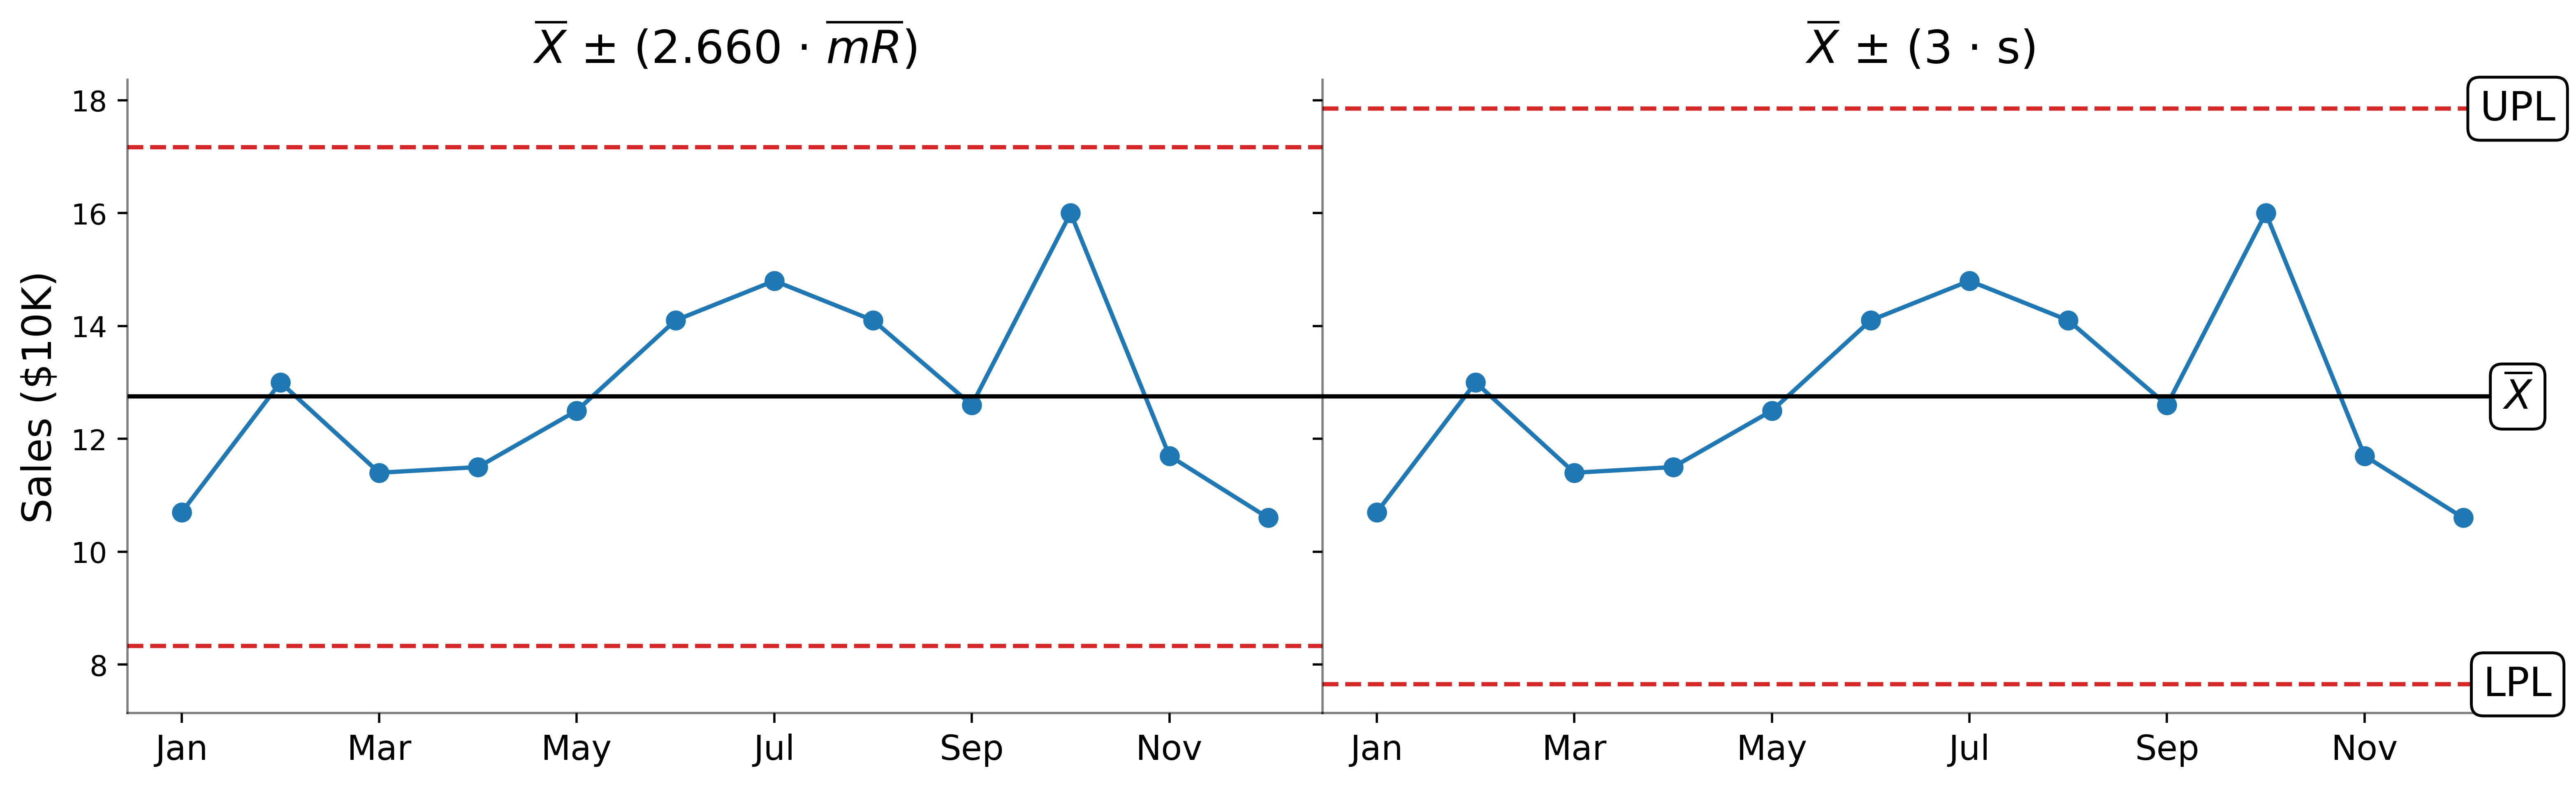

In [7]:
# Prepare plotting data
labels = df_east['Month']
east_data = df_east['Sales']

# Create the figure
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,4), dpi=500)
# fig.suptitle('East Region Sales',fontsize=20, y=1.1)
plt.subplots_adjust(wspace=0) # Reduce white space

# Plot data on both subplots
for ax in axs:
    ax.plot(labels, east_data, marker='o')
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, fontsize=12)
    
# Define process limits for each subplot
limits = [
    (axs[0], [east_stats['UPL_E2'], east_stats['LPL_E2'], east_stats['Mean']]),
    (axs[1], [east_stats['UPL_3sigma'], east_stats['LPL_3sigma'], east_stats['Mean']])
]

# Colors for each limit line
colors = ['tab:red', 'tab:red', 'black']
linestyles = ['--', '--', '-']

# Add process limits dynamically
for ax, values in limits:
    for value, linestyle, color in zip(values, linestyles, colors):
        ax.axhline(value, ls=linestyle, color=color)

# Set subplot titles
plot_titles = ['$\overline{X}$ $\pm$ (2.660 $\cdot$ $\overline{mR}$)', '$\overline{X}$ $\pm$ (3 $\cdot$ s)']
for ax, title in zip(axs, plot_titles):
    ax.set_title(title, fontsize=16)
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_alpha(0.5)
#     ax.set_yticks([])

# Specify axis labels and title
axs[0].set_ylabel('Sales ($10K)',fontsize=14)
# axs[0].set_yticklabels([])

# Add text labels for limits and centerline
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)
axs[1].text(axs[1].get_xlim()[1], east_stats['UPL_3sigma'], 'UPL', color='black', ha='center', va='center', 
            fontsize=14, bbox=bbox_props)
axs[1].text(axs[1].get_xlim()[1], east_stats['LPL_3sigma'], 'LPL', color='black', ha='center', va='center', 
            fontsize=14, bbox=bbox_props)
axs[1].text(axs[1].get_xlim()[1], east_stats['Mean'], r'$\overline{X}$', color='black', ha='center', va='center', 
            fontsize=14, bbox=bbox_props)

# x-axis Formatting
tick_interval = 2
tick_positions = np.arange(0, len(labels), tick_interval)

for ax in axs:
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(labels.iloc[tick_positions], 
                       rotation=0, 
                       ha='center', 
                       fontsize=12)

# Show plot
plt.show()

## Figure 16.2: West Region sales comparison of limits

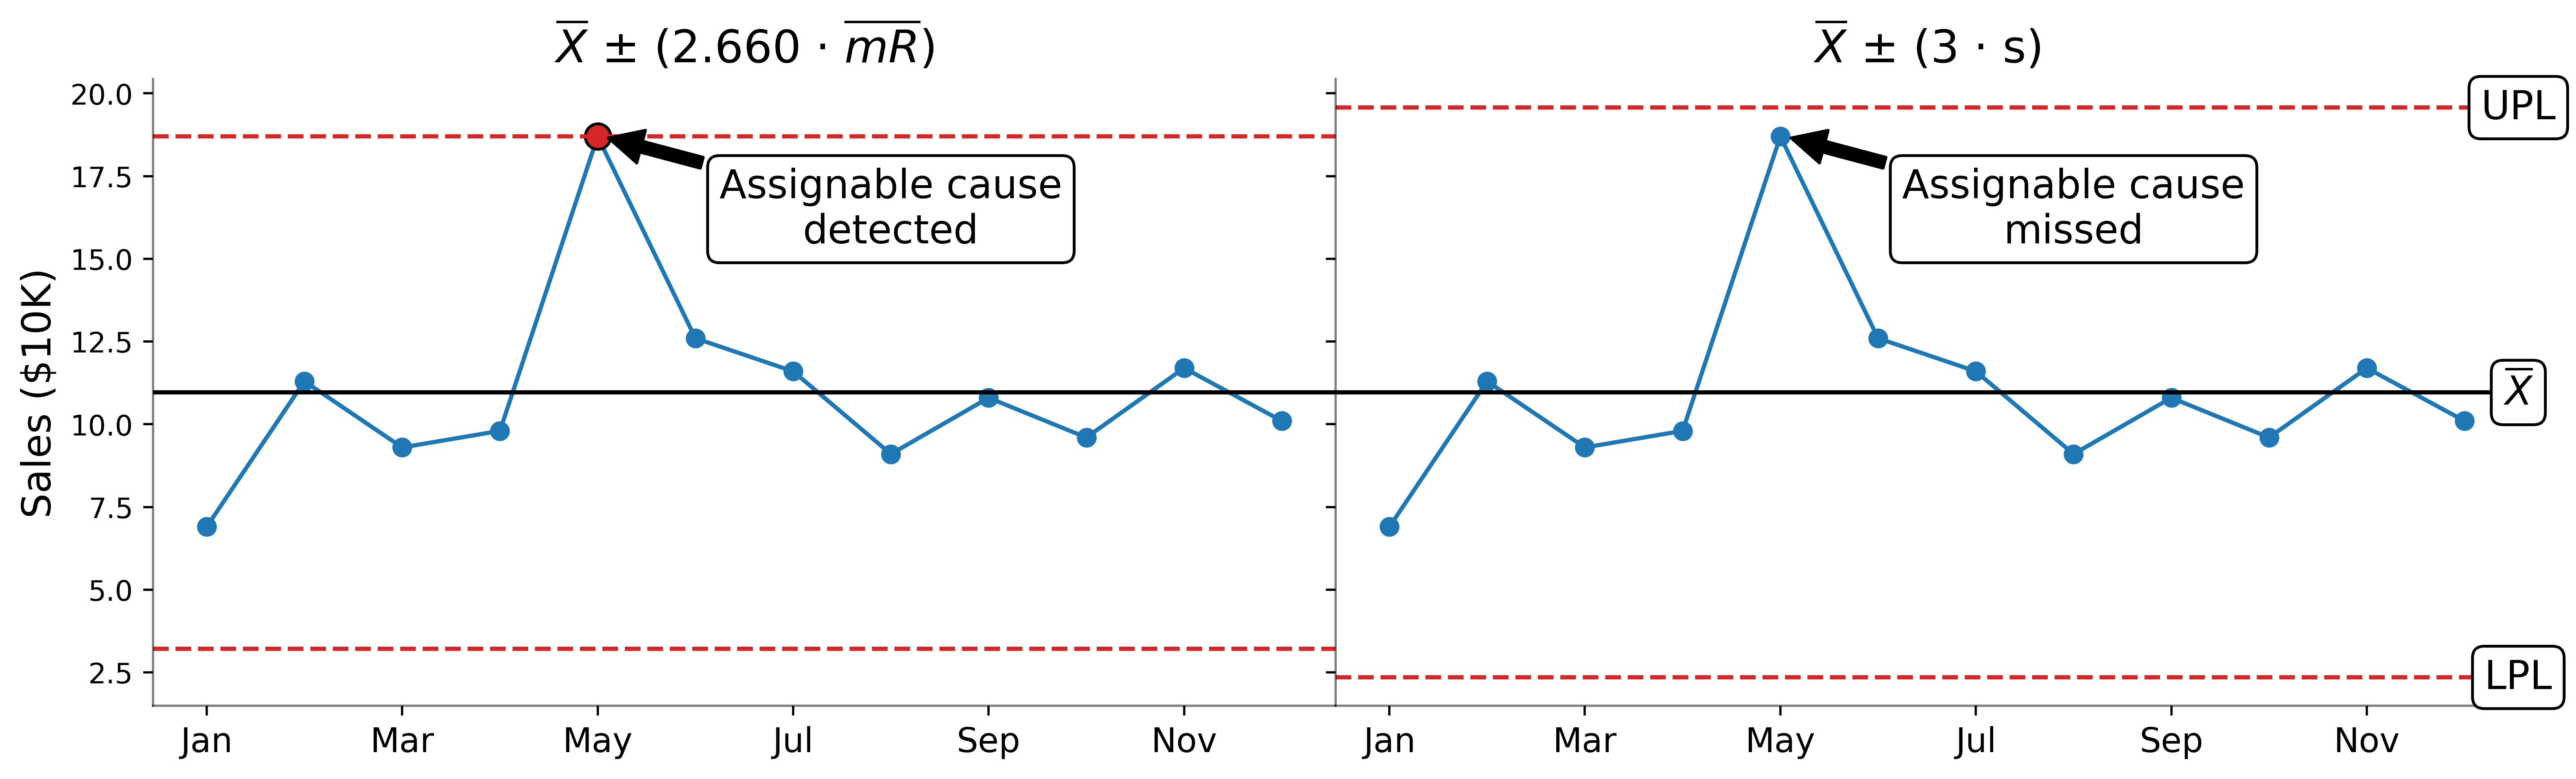

In [8]:
# Prepare plotting data
labels = df_west['Month']
west_data = df_west['Sales']

# Create masking parameters for valuesoutside limits
upper_lim_1 = np.ma.masked_where(west_data < west_stats['UPL_E2'], west_data)
lower_lim_1 = np.ma.masked_where(west_data > west_stats['LPL_E2'], west_data)
upper_lim_2 = np.ma.masked_where(west_data < west_stats['UPL_3sigma'], west_data)
lower_lim_2 = np.ma.masked_where(west_data > west_stats['LPL_3sigma'], west_data)

# Create the figure
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,4), dpi=500)
# fig.suptitle('West Region',fontsize=20, y=1.1)
plt.subplots_adjust(wspace=0) # Reduce white space

# Plot data on both subplots
for ax in axs:
    ax.plot(labels, west_data, marker='o')
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, fontsize=12)
    
# Greater than Upper Process Limit values
axs[0].plot(labels, upper_lim_1, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)
axs[1].plot(labels, upper_lim_2, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)
    
# Define process limits for each subplot
limits = [
    (axs[0], [west_stats['UPL_E2'], west_stats['LPL_E2'], west_stats['Mean']]),
    (axs[1], [west_stats['UPL_3sigma'], west_stats['LPL_3sigma'], west_stats['Mean']])
]

# Colors for each limit line
colors = ['tab:red', 'tab:red', 'black']
linestyles = ['--', '--', '-']

# Add process limits dynamically
for ax, values in limits:
    for value, linestyle, color in zip(values, linestyles, colors):
        ax.axhline(value, ls=linestyle, color=color)

# Set subplot titles
plot_titles = ['$\overline{X}$ $\pm$ (2.660 $\cdot$ $\overline{mR}$)', '$\overline{X}$ $\pm$ (3 $\cdot$ s)']
for ax, title in zip(axs, plot_titles):
    ax.set_title(title, fontsize=16)
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_alpha(0.5)
#     ax.set_yticks([])

# Specify axis labels and title
axs[0].set_ylabel('Sales ($10K)',fontsize=14)
# axs[0].set_yticklabels([])

# Add text labels for limits and centerline
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)
axs[1].text(axs[1].get_xlim()[1], west_stats['UPL_3sigma'], 'UPL', color='black', ha='center', va='center', 
            fontsize=14, bbox=bbox_props)
axs[1].text(axs[1].get_xlim()[1], west_stats['LPL_3sigma'], 'LPL', color='black', ha='center', va='center', 
            fontsize=14, bbox=bbox_props)
axs[1].text(axs[1].get_xlim()[1], west_stats['Mean'], r'$\overline{X}$', color='black', ha='center', va='center', 
            fontsize=14, bbox=bbox_props)

# x-axis Formatting
tick_interval = 2
tick_positions = np.arange(0, len(labels), tick_interval)

# Set xticks and labels
for ax in axs:
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(labels.iloc[tick_positions], 
                       rotation=0, 
                       ha='center', 
                       fontsize=12)
    
# Annotation parameters
annotations = [
    ('Assignable cause\ndetected', axs[0], (4.05,18.7), (7,16.5)),
    ('Assignable cause\nmissed', axs[1], (4.05,18.7), (7,16.5))
]

# Plot annotations
for text, ax, xy, xytext in annotations:
    ax.annotate(
        text,
        xy=xy,
        xytext=xytext,
        fontsize=14,
        ha='center',
        va='center',
        color='black',
        arrowprops=dict(facecolor='black', shrink=0.05),
        bbox=dict(facecolor='white', boxstyle='round', edgecolor='black')
    )
    
# Show plot
plt.show()